Files already downloaded and verified
Sparsity: 0.0, Computation Time: 12.4402 seconds, Accuracy: 0.00%
Sparsity: 0.1, Computation Time: 7.3054 seconds, Accuracy: 0.00%
Sparsity: 0.2, Computation Time: 6.9924 seconds, Accuracy: 0.00%
Sparsity: 0.30000000000000004, Computation Time: 7.2159 seconds, Accuracy: 0.00%
Sparsity: 0.4, Computation Time: 7.2613 seconds, Accuracy: 0.00%
Sparsity: 0.5, Computation Time: 7.3760 seconds, Accuracy: 1.00%
Sparsity: 0.6000000000000001, Computation Time: 7.0936 seconds, Accuracy: 0.00%
Sparsity: 0.7000000000000001, Computation Time: 7.0760 seconds, Accuracy: 0.00%
Sparsity: 0.8, Computation Time: 7.0738 seconds, Accuracy: 0.00%
Sparsity: 0.9, Computation Time: 7.1714 seconds, Accuracy: 0.00%
Sparsity: 1.0, Computation Time: 7.4189 seconds, Accuracy: 10.00%


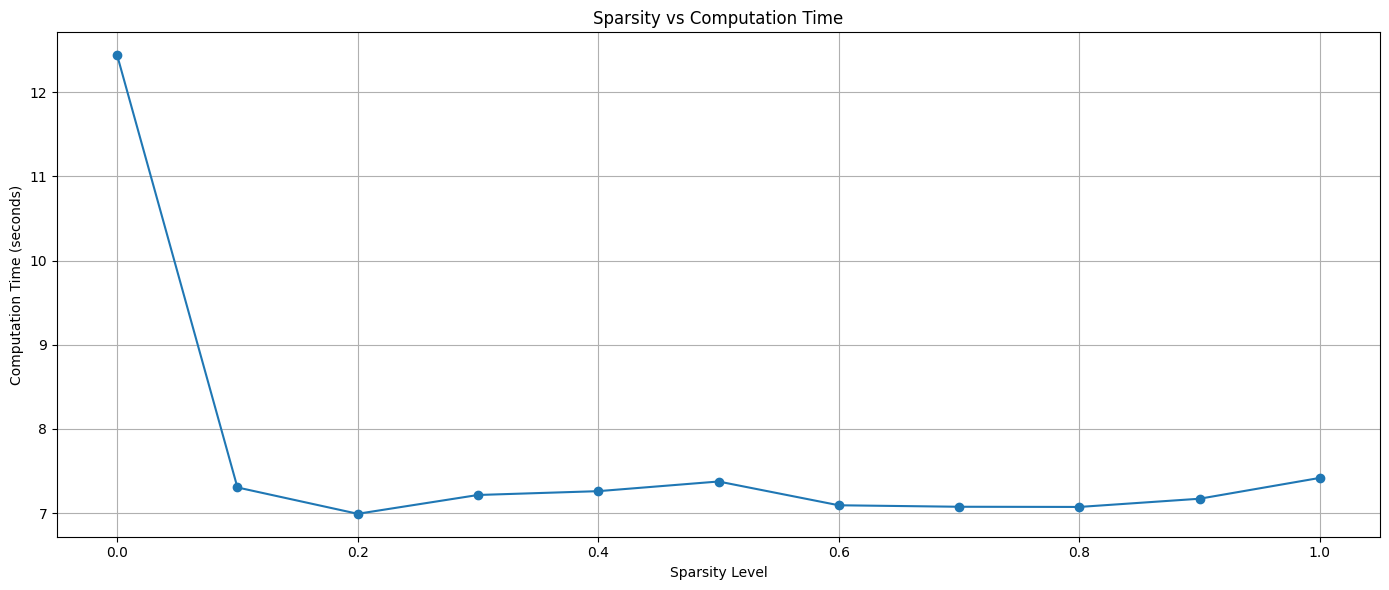

In [7]:
import time

try:
    import torch
    import torch.nn as nn
    import torch.nn.utils.prune as prune
    import torchvision.models as models
    import torchvision.transforms as transforms
    import torchvision.datasets as datasets
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    import numpy
except ModuleNotFoundError as e:
    print("Required module not found. Please ensure PyTorch, torchvision, and matplotlib are installed.")
    print("Install using: pip install torch torchvision matplotlib")
    raise e

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Define a pruning function
def prune_model_individual(model, amount):
    """
    Prune each layer of the model individually by the given amount.

    Args:
        model (nn.Module): The model to prune.
        amount (float): The fraction of connections to prune.

    Returns:
        nn.Module: The pruned model.
    """
    for _, module in model.named_modules():
        # Prune only Conv2d and Linear layers
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=amount)
            if module.bias is not None:
                prune.l1_unstructured(module, name='bias', amount=amount)
    return model

# Load the dataset (using CIFAR-10 as an example)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

try:
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
except Exception as e:
    print("Error loading datasets. Ensure you have internet access and sufficient storage.")
    raise e

test_loader = DataLoader(torch.utils.data.Subset(test_dataset, range(100)), batch_size=32, shuffle=False)

# Define evaluation functions
def evaluate_computation_time(model):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for images, labels in test_loader:
            _ = model(images)
    end_time = time.time()
    return end_time - start_time


def evaluate_model_accuracy(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (100 * (correct / total))

# Sparsity levels
sparsity_levels = numpy.arange(0.0, 1.1, 0.1)
computation_times = []
accuracies = []

for sparsity in sparsity_levels:
    # Clone the original model to keep it unmodified
    model_copy = models.vgg16(pretrained=True)
    pruned_model = prune_model_individual(model_copy, amount=sparsity)
    comp_time = evaluate_computation_time(pruned_model)
    computation_times.append(comp_time)
    accuracy = evaluate_model_accuracy(pruned_model)
    accuracies.append(accuracy)
    print(f"Sparsity: {sparsity}, Computation Time: {comp_time:.4f} seconds, Accuracy: {accuracy:.2f}%")

# Plot the graphs
plt.figure(figsize=(14, 6))

# Plot 1: Sparsity vs Computation Time
# plt.subplot(1, 2, 1)
plt.plot(sparsity_levels, computation_times, marker='o')
plt.title("Sparsity vs Computation Time")
plt.xlabel("Sparsity Level")
plt.ylabel("Computation Time (seconds)")
plt.grid(True)

# Plot 2: Sparsity vs Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(sparsity_levels, accuracies, marker='o')
# plt.title("Sparsity vs Accuracy")
# plt.xlabel("Sparsity Level")
# plt.ylabel("Accuracy (%)")
# plt.grid(True)

plt.tight_layout()
plt.show()